In [130]:
#Text Extraction from PDFs:
#Libraries for text extraction
#PyMuPDF (Fitz) it's known for efficient and accurate text extraction, which is crucial for sentiment analysis.
!pip install PyMuPDF

import fitz
import re
import os
import csv
import zipfile


from keras.models import Sequential

In [129]:
#Preparing data by importing
import pandas as pd
data = pd.read_csv('/content/sentimentsdata_V3.csv')

#Convert the "News Data" column in a dateframe format
data['News Date'] = pd.to_datetime(data['News Date'])

columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
filtered_data = data.drop(columns=columns_to_drop)

filtered_data['Remark'] = filtered_data['Remark'].replace({'sadness': 'Sadness'})


In [131]:
data['News Date']

0     2023-01-23
1     2023-07-30
2     2022-12-01
3     2022-10-14
4     2023-02-02
         ...    
751   2023-01-21
752   2023-01-27
753   2023-06-17
754   2023-02-19
755   2022-10-06
Name: News Date, Length: 756, dtype: datetime64[ns]

In [132]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

!pip install transformers
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")
import torch
from transformers import AutoTokenizer, AutoModel

In [133]:
filtered_data.head()

,News Article,News Date,Sentiment,Remark
0,Während die Ukraine weiter auf Kampfpanzer aus...,2023-01-23,3,Anger
1,"Es kommt selten vor, dass ein General öffentli...",2023-07-30,3,Anger
2,VON MARKUS DECKER UND SVEN CHRISTIAN SCHULZ (R...,2022-12-01,3,Anger
3,Sie können es nicht richtig machen Heft 41/202...,2022-10-14,5,Disgust
4,Ein Ausweg aus dem Wolkenkuckucksheim Immer wi...,2023-02-02,5,Disgust


In [134]:
df_filtered = filtered_data.copy()

In [135]:
df_filtered.columns

Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')

In [136]:
#define function remove_german_punctuation, takes a text input and performs several operations to remove German punctuation and standardize the text

import string
def remove_german_punctuation(text):
    german_punctuation = ".,;!?()[]{}<>\"'„“‚‘«»-–—/:"
    #The str.maketrans method creates a translation table. It takes three arguments: characters to be replaced, characters to replace them with, and characters to be removed. In this case, the first two arguments are empty strings (''), indicating that the specified German punctuation characters are to be removed.
    translator = str.maketrans('', '', german_punctuation)

    text = text.translate(translator)
    text = re.sub(r"\s+", ' ', text).lower()

    return text

In [138]:
#Pretrained model to tokenize the text.
from transformers import AutoModel, AutoTokenizer

#the model variable will be used for the embeddings in the next steps
model_name = "bert-base-german-cased"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [139]:

from transformers import DistilBertTokenizer
from tokenizers import BertWordPieceTokenizer #AutoModel and AutoTokenizer are part of the Hugging Face Transformers library and are used for seamless loading of pre-trained models and tokenizers. They are user-friendly and abstract away many details, making it easy to work with a variety of models and languages.

# Load the real tokenizer
# Initializes a pre-trained BERT-based tokenizer for the German language from the Hugging Face Transformers library.
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-german-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


Tokenizer(vocabulary_size=30000, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [140]:

import numpy as np
from tqdm import tqdm

#Input Parameters: The function takes several input parameters:
def fast_encode_and_embed(texts, tokenizer, model, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding()
    all_embeddings = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist() # Clean text within chunk_size boundary
        clean_text_chunk = [remove_german_punctuation(str(text)) for text in text_chunk]
        encs = tokenizer.encode_batch(clean_text_chunk) #Tokenizes and encodes the cleaned text chunk using the provided tokenizer. It returns a list of encoded sequences (encs).

        # Converting  encoded sequences (enc.ids) to tensors, getting embeddings
        # This is necessary to prepare the input for the BERT model.
        input_ids = [torch.tensor(enc.ids) for enc in encs]
        input_tensors = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True)  # Padded sequence
        with torch.no_grad():
            output = None
            output = model(input_ids=input_tensors) # Using the pre-trained BERT model to generate embeddings for the input tensors. The embeddings are obtained from the last hidden state of the model.
        embeddings = output.last_hidden_state[:, 0, :].numpy() #extracts the embeddings for the [CLS] token (the first token in each sequence) from the last hidden state of the BERT model. These embeddings are then converted to NumPy arrays.
        all_embeddings.extend(embeddings) # appends the embeddings from the current chunk to the all_embeddings list. This list accumulates the embeddings for all text samples.

    return np.array(all_embeddings) # function returns a NumPy array containing all the embeddings for the input text samples

In [141]:
pip install numpy tqdm torch matplotlib seaborn


In [142]:
#Sets up configuration parameters for a NLP task.
#Asignig the autotune, when the model is getting trained.
#autotune is that when the model is getting trained, and whe we put it into autotune it will do computation parallel, to speed up the model.

#IMP DATA FOR CONFIG
AUTO = tf.data.experimental.AUTOTUNE #AUTOTUNE is used to automatically tune and optimize the performance of data input pipelines. It allows TensorFlow to dynamically adjust the level of parallelism based on the available system resources, making data loading and processing more efficient.

#These are to instantiate, but they will be changed/updated down.
# Configuration
EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 512

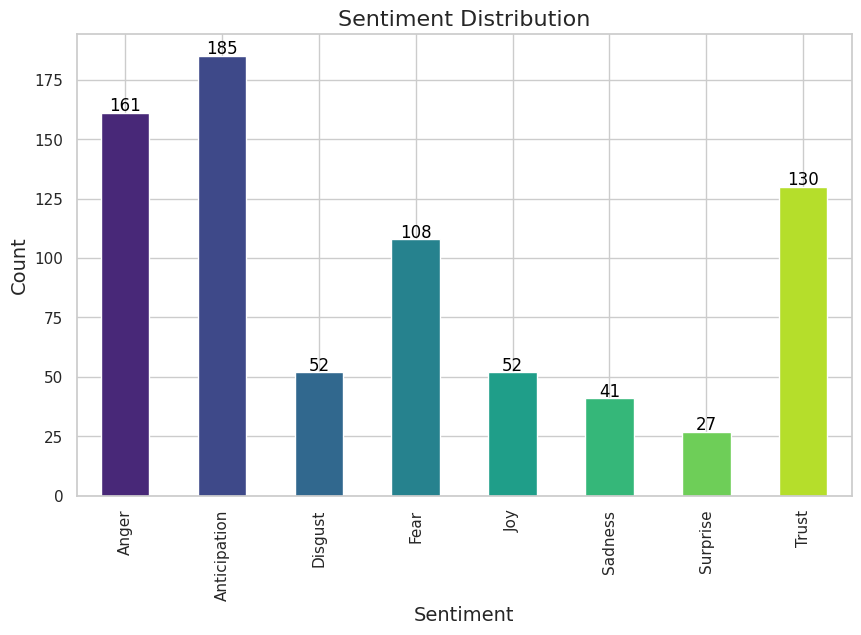

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create the bar plot
ax = df_filtered["Remark"].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color=sns.color_palette("viridis", len(df_filtered["Sentiment"].unique())))

# Set title and labels
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Show the plot
plt.show()


In [144]:
df_filtered.columns

Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')

In [145]:
#Downsampling, because the minority class had just 27, we did the other also in 27.

import pandas as pd
from sklearn.utils import resample

# Define the different sentiment classes
sentiments = df_filtered['Sentiment'].unique()

# Find the minimum count among the sentiment classes to downsample other classes to this count
min_count = min(df_filtered['Sentiment'].value_counts())

# Initialize a list to hold the downsampled DataFrames
dfs_downsampled = []

for sentiment in sentiments:
    sentiment_df = df_filtered[df_filtered['Sentiment'] == sentiment]

    # Downsample (or just slice) the DataFrame of the current class to the minimum count
    downsampled_df = resample(sentiment_df, replace=False, n_samples=min_count, random_state=42) if len(sentiment_df) > min_count else sentiment_df

    # Append the downsampled/sliced DataFrame to the list
    dfs_downsampled.append(downsampled_df)

# Concatenate all the downsampled DataFrames to get the final balanced DataFrame
df_balanced = pd.concat(dfs_downsampled)

# Shuffle the DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [146]:
# Print column names after creating df_balanced
print(df_balanced.columns)


Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')


In [147]:
df_balanced.columns

Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')

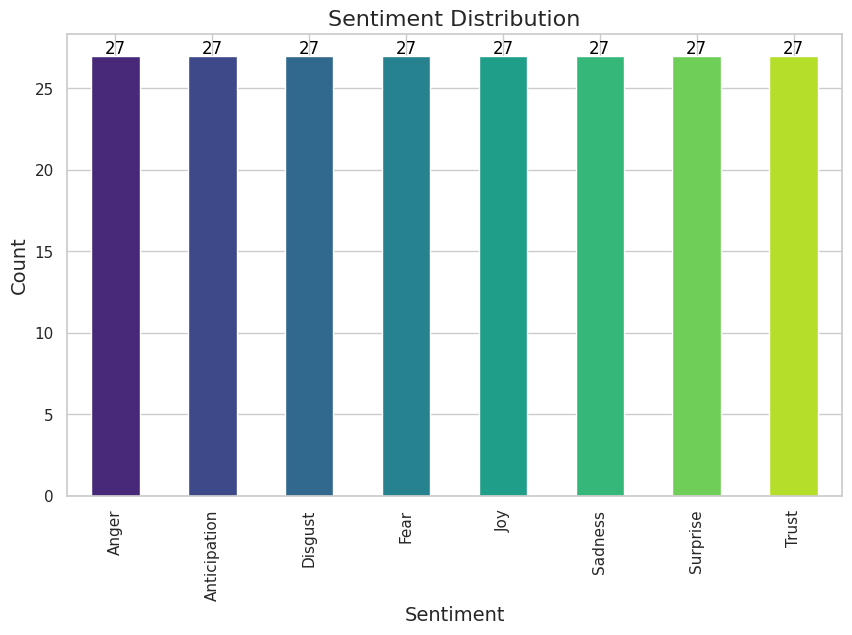

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create the bar plot
ax = df_balanced["Remark"].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color=sns.color_palette("viridis", len(df_filtered["Sentiment"].unique())))

# Set title and labels
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Show the plot
plt.show()


In [149]:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [150]:
df_balanced.columns

Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')

In [151]:
TF_ENABLE_ONEDNN_OPTS=1
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [152]:

# Split the data into training (80%) and temporary data (20%)
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, random_state=42)

# Further split the temporary data into validation (50%) and test (50%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
# This would create 70:15:15 split

In [153]:
df_balanced.columns

Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')

In [154]:
df_filtered.columns

Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')

In [155]:
# Encoding and preparing X and y for the training, validation, and test sets


# Training set
#x_train stores the embeddings of the training text data. It uses the fast_encode_and_embed function to encode and embed the text data from the train_df['News Article'] column. The embeddings are generated using the BERT-based model (model) and the specified tokenizer (fast_tokenizer).
x_train = fast_encode_and_embed(train_df['News Article'].astype(str), fast_tokenizer, maxlen=MAX_LEN, model=model)
y_train = train_df['Sentiment'].values #y_train stores the labels (sentiments) corresponding to the training text data.
# Validation set
#x_valid stores the embeddings of the validation text data.
#x_valid uses the fast_encode_and_embed function to encode and embed the text data from the val_df['News Article'] column
x_valid = fast_encode_and_embed(val_df['News Article'].astype(str), fast_tokenizer, maxlen=MAX_LEN,  model=model)
y_valid = val_df['Sentiment'].values

# Test set
x_test = fast_encode_and_embed(test_df['News Article'].astype(str), fast_tokenizer, maxlen=MAX_LEN,  model=model)


100%|██████████| 1/1 [00:58<00:00, 58.76s/it]


In [156]:
y_test = test_df['Sentiment'].values


In [ ]:
#np.save('x_train.npy', x_train)
#np.save('y_train.npy', y_train)
#np.save('x_valid.npy', x_valid)
#np.save('y_valid.npy', y_valid)
#np.save('x_test.npy', x_test)


In [157]:
train_df['Remark'].value_counts().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of Surprise        24
Anger           22
Sadness         20
Joy             19
Anticipation    17
Fear            17
Disgust         16
Trust           16
Name: Remark, dtype: int64>

In [158]:
x_train.shape

(151, 768)

In [159]:
x_valid.shape

(32, 768)

In [160]:
x_test.shape

(33, 768)

In [161]:
# one-hot encoded our labels (y_train)
#to represent categorical labels numerically.
from keras.utils import to_categorical
num_classes = 8  # Number of classes
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)


# LSTM Model, after the embeddings

In [162]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
checkpoint_callback = ModelCheckpoint("model_checkpoint.h5", save_best_only=True)
# early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)
np.random.seed(42)
tf.random.set_seed(42)

# Define LSTM model
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(768,1)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 768, 512)          1052672   
                                                                 
 dropout_2 (Dropout)         (None, 768, 512)          0         
                                                                 
 lstm_5 (LSTM)               (None, 768, 256)          787456    
                                                                 
 dropout_3 (Dropout)         (None, 768, 256)          0         
                                                                 
 lstm_6 (LSTM)               (None, 768, 256)          525312    
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 8)                

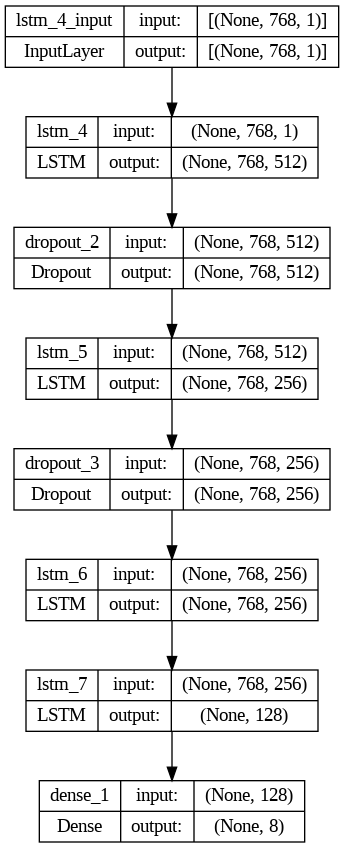

In [163]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [178]:
# Training the model
batch_size = 32
epochs = 50

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback] ,validation_data=(x_valid, y_valid), shuffle=False)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/50
5/5 [==============================] - 1s 280ms/step - loss: 0.6702 - accuracy: 0.7881 - val_loss: 3.5051 - val_accuracy: 0.0938
Epoch 2/50
5/5 [==============================] - 1s 269ms/step - loss: 0.6242 - accuracy: 0.7947 - val_loss: 3.6464 - val_accuracy: 0.1562
Epoch 3/50
5/5 [==============================] - 1s 270ms/step - loss: 0.5071 - accuracy: 0.8411 - val_loss: 3.5854 - val_accuracy: 0.1250
Epoch 4/50
5/5 [==============================] - 1s 282ms/step - loss: 0.4462 - accuracy: 0.8675 - val_loss: 3.7276 - val_accuracy: 0.1562
Epoch 5/50
5/5 [==============================] - 1s 274ms/step - loss: 0.4340 - accuracy: 0.8808 - val_loss: 3.7033 - val_accuracy: 0.1562
Epoch 6/50
5/5 [==============================] - 1s 272ms/step - loss: 0.4542 - accuracy: 0.8477 - val_loss: 3.9112 - val_accuracy: 0.1875
Epoch 7/50
5/5 [==============================] - 1s 272ms/step - loss: 0.3822 - accuracy: 0.8874 - val_loss: 4.0426 - val_accuracy: 0.1562
Epoch 8/50
5/5 [====

2/2 [==============================] - 0s 104ms/step
Accuracy: 0.18181818181818182
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
Anticipation       0.17      0.25      0.20         4
     Disgust       0.25      0.60      0.35         5
        Fear       0.00      0.00      0.00         3
         Joy       0.00      0.00      0.00         3
     Sadness       0.33      0.14      0.20         7
    Surprise       0.00      0.00      0.00         2
       Trust       0.25      0.20      0.22         5

    accuracy                           0.18        33
   macro avg       0.12      0.15      0.12        33
weighted avg       0.17      0.18      0.15        33



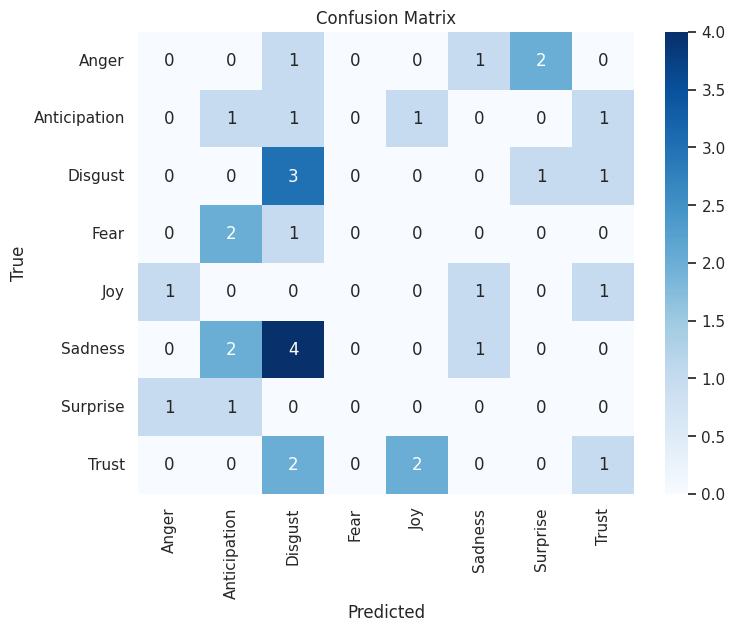

In [165]:
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics such as accuracy, precision, recall, and F1-score
accuracy = np.mean(y_pred_classes == y_true)
report = classification_report(y_true, y_pred_classes, target_names=['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'])
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print the evaluation results
print(f'Accuracy: {accuracy}')
print(report)

# Generate and plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'], yticklabels=['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [166]:
pip install torch captum


In [167]:
print(df_balanced.columns)


Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')


In [168]:
print(df_balanced.columns)


Index(['News Article', 'News Date', 'Sentiment', 'Remark'], dtype='object')


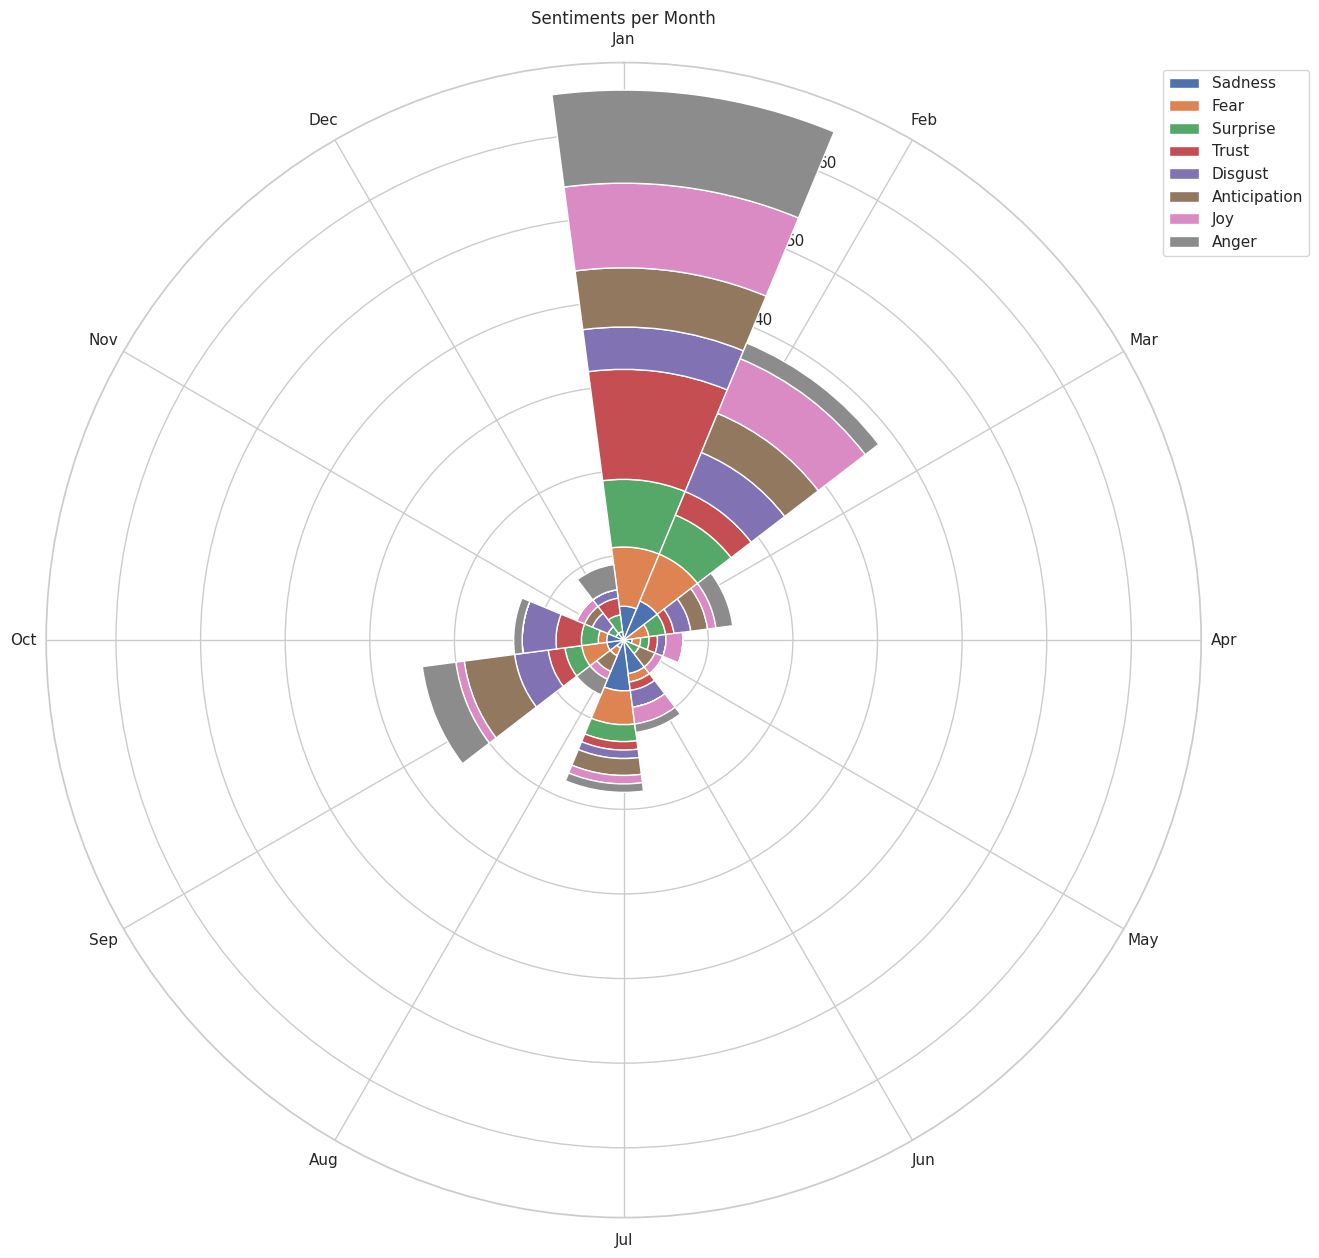

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_balanced['News Date'] = pd.to_datetime(df_balanced['News Date'])

# Extract the month from the News Date
df_balanced['Month'] = df_balanced['News Date'].dt.month

# Count the occurrences of sentiments by month
byMonthSentiments = df_balanced.groupby(['Month', 'Remark']).size().unstack(fill_value=0)

N = 12  # 12 months in a year

# Creating theta for 12 months
theta = np.linspace(7.5*np.pi/180, 2 * np.pi + 7.5*np.pi/180, N, endpoint=False)

# Setting the properties for a polar plot
radii, tick = np.histogram(range(N), bins=N)
width = (2*np.pi) / N

# Plotting a polar plot
plt.figure(figsize=(15, 15))
ax = plt.subplot(111, projection='polar')
plt.title("Sentiments per Month")

# Setting the ticks
thetaticks = np.arange(0, 360, 30)
ax.set_thetagrids(thetaticks)

# Initialize bottom as an array of zeros
bottom = np.zeros(N)

for sentiment in df_balanced['Remark'].unique():
    values = byMonthSentiments[sentiment].tolist()
    bars = ax.bar(theta, values, width=width, bottom=bottom, label=sentiment)
    bottom += np.array(values)

# Set labels to go clockwise and start from the top
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Setting the labels
ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(ticks)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.show()


In [170]:
df_balanced.columns

Index(['News Article', 'News Date', 'Sentiment', 'Remark', 'Month'], dtype='object')

In [171]:
print(df_balanced.columns)


Index(['News Article', 'News Date', 'Sentiment', 'Remark', 'Month'], dtype='object')


In [172]:
import plotly.graph_objects as go

train_df['News Date'] = pd.to_datetime(train_df['News Date'])

# Filter data for January and February
filtered_df = train_df[(train_df['News Date'].dt.month == 1) | (train_df['News Date'].dt.month == 2)]

# Extract the month from the News Date
filtered_df['Month'] = filtered_df['News Date'].dt.strftime('%B')  # Get full month name

# Count the occurrences of sentiments by month
byMonthSentiments = filtered_df.groupby(['Month', 'Remark']).size().unstack(fill_value=0)

# Define categories based on sentiments
categories = filtered_df['Remark'].unique()

# Create a radar chart using Plotly
fig = go.Figure()

for month in filtered_df['Month'].unique():
    values = byMonthSentiments.loc[month].tolist()
    values += values[:1]  # Close the loop
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=month
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, byMonthSentiments.max().max()]  # Adjust the range based on your data
        )),
    showlegend=True
)

fig.show()


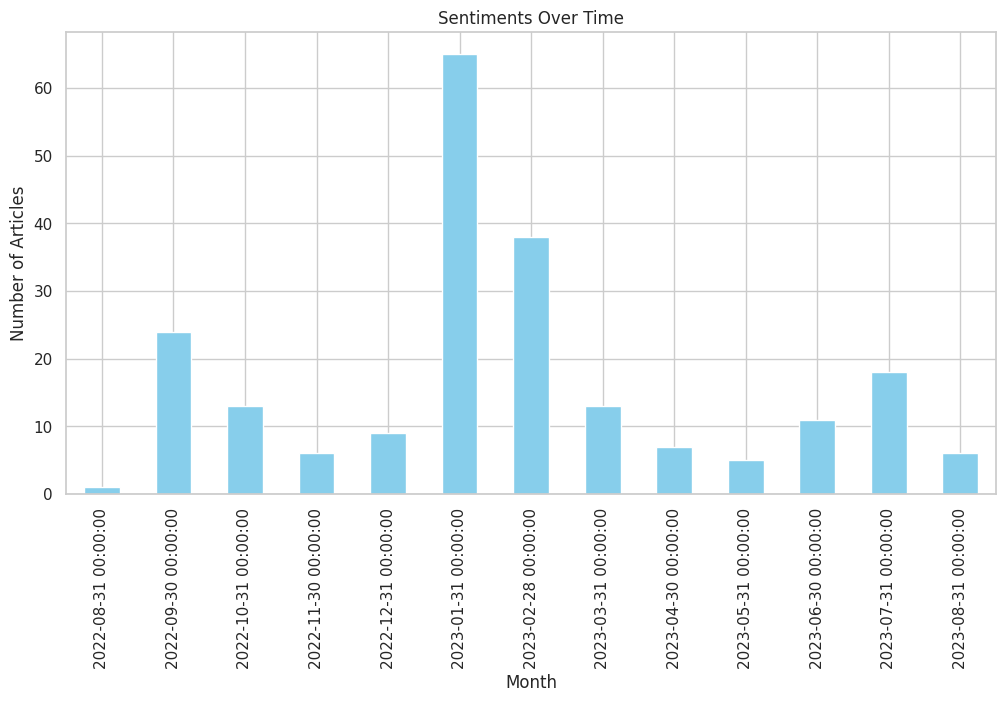

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

df_balanced['News Date'] = pd.to_datetime(df_balanced['News Date'])

# Create 'Month' column
df_balanced['Month'] = df_balanced['News Date'].dt.month_name()

# Set 'News Date' as the index for better plotting
df_balanced.set_index('News Date', inplace=True)

# Resample data to get a count of sentiments per month
sentiments_per_month = df_balanced.resample('M').size()

# Plotting
plt.figure(figsize=(12, 6))
sentiments_per_month.plot(kind='bar', color='skyblue')
plt.title('Sentiments Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.show()



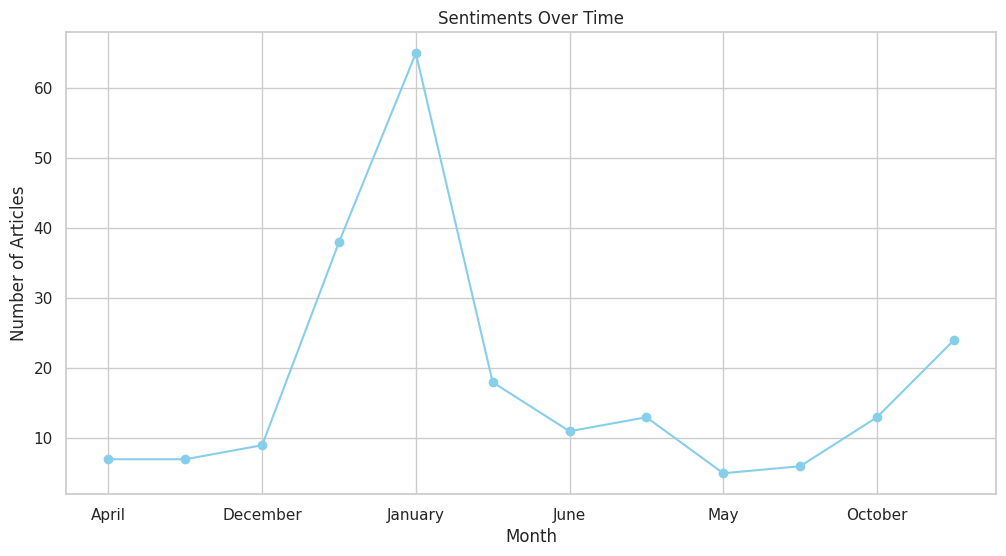

In [176]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the occurrences of sentiments by month
byMonthSentiments = df_balanced.groupby('Month').size()

# Plotting
plt.figure(figsize=(12, 6))
byMonthSentiments.plot(kind='line', marker='o', color='skyblue')
plt.title('Sentiments Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()
